Santeri Hynninen

CASE: F1 EMILIA-ROMAGNAN GP 2024
GOAL: Predict the top 5 drivers for the race

APPROACH

First thoughts: The tracks, cars and drivers are different are changing every time: not that much datapoints
                The track characteristics could have big impact of how well the car and the driver performs
                We should compare the drivers performance to the track characterictics

DATA Sources:    GeoJson data from the most of the tracks: https://github.com/bacinger/f1-circuits/tree/master/circuits
                 Race statistics from: https://github.com/f1db/f1db/

                Final dataframe should be something like
                Year, Driver, Team, Weather(maybe), n x (different track attributes), placement

RESTRICTIONS:   There have been large changes to the cars in season 2022, thus we will use data only from seasons 2022-2024
                Tiremanufacturer is Pirel for every driver

TRACK ATTRIBUTES:       We would like to have the charestics of track - what are these charestics?
                        Note that we dont have to project the geodata because we are looking relative attributes of the data
                        Straights: 
                        Curves:  [over40, over30, over15, avg, stdev, avg_diff, stdev_diff]

HOW SPECIAL CASES ARE HANDELED:
                        Categorial data(engine manufacturer and driver) are one hot encoded: https://en.wikipedia.org/wiki/One-hot
                        (each category value is changed to truth column)

                        NAs(only in position column when the driver did not finish)
                        These values are removed because the prediction is impossible
                

In [357]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import math
import statistics as stat
import os
from sklearn.preprocessing import minmax_scale

In [358]:
def pointDistance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

In [359]:
def geoDataImport(filename = r"data\circuits\ae-2009.geojson"):
    gdata = gpd.read_file(filename)
    points = gdata['geometry'][0].coords[:]
    straight = []

    straight.append(pointDistance(points[0],points[1]))
    for i in range(1, len(points)-1):
        straight.append(pointDistance(points[i],points[i+1]))
    
    return gdata['Name'][0], round(max(straight)*10**5,2)

In [360]:
track_names = {
    'Bahrain International Circuit': 'bahrain',
    'Jeddah Corniche Circuit': 'jeddah',
    'Suzuka International Racing Course': 'suzuka',
    'Albert Park Circuit': 'melbourne',
    'Yas Marina Circuit': 'yas-marina',
    'Autódromo José Carlos Pace - Interlagos': 'interlagos',
    'Autódromo Hermanos Rodríguez': 'mexico-city',
    'Circuit of the Americas': 'austin',
    'Marina Bay Street Circuit': 'marina-bay',
    'Autodromo Nazionale Monza': 'monza',
    'Circuit Zandvoort': 'zandvoort',
    'Circuit de Spa-Francorchamps': 'spa-francorchamps',
    'Hungaroring': 'hungaroring',
    'Red Bull Ring': 'spielberg',
    'Silverstone Circuit': 'silverstone',
    'Circuit Gilles-Villeneuve': 'montreal',
    'Baku City Circuit': 'baku',
    'Circuit de Monaco': 'monaco',
    'Circuit de Barcelona-Catalunya': 'catalunya',
    'Miami International Autodrome': 'miami',
    'Circuit Paul Ricard': 'paul-ricard',
    'Autodromo Enzo e Dino Ferrari': 'imola',
    'Losail International Circuit': 'losail',
    'Las Vegas Street Circuit': 'las-vegas',
    'Shanghai International Circuit': 'shanghai'
}

def TrackData():
    columns = ('Name','max_straight')
    df = pd.DataFrame(columns=columns)
    arr = os.listdir('data\\circuits\\')
    for file in arr:
        name, max_straight = (geoDataImport('data\\circuits\\'+file))
        try:
            name = track_names[name]
        except KeyError:
            continue

        df_temp = pd.DataFrame([list((name, max_straight))], columns=df.columns)
        df = pd.concat([df, df_temp])
    df['max_straight'] = df['max_straight'].apply(lambda x:  (x-df['max_straight'].min())/(df['max_straight'].max()-df['max_straight'].min()))
    return df   

df = TrackData()
df


,Name,max_straight
0,yas-marina,0.172701
0,spielberg,0.210294
0,melbourne,0.288078
0,baku,0.148579
0,spa-francorchamps,0.196254
0,bahrain,0.484161
0,interlagos,0.055159
0,montreal,0.409479
0,shanghai,0.284877
0,catalunya,0.365222


In [361]:
def racePlacement():
    df = pd.read_csv(r'data\f1db-races-race-results.csv')
    df = df[['raceId','year','positionNumber', 'driverId']]
    df = df[df['year'].isin([2024, 2023, 2022])]
    return df

df = racePlacement()
df

,raceId,year,positionNumber,driverId
25452,1058,2022,1.0,charles-leclerc
25453,1058,2022,2.0,carlos-sainz-jr
25454,1058,2022,3.0,lewis-hamilton
25455,1058,2022,4.0,george-russell
25456,1058,2022,5.0,kevin-magnussen
...,...,...,...,...
26426,1106,2024,16.0,kevin-magnussen
26427,1106,2024,17.0,logan-sargeant
26428,1106,2024,NaN,daniel-ricciardo
26429,1106,2024,NaN,yuki-tsunoda


In [362]:
def raceTracks():    
    df = pd.read_csv(r'data\f1db-races.csv')
    df = df[['id','year','circuitId']]
    df = df[df['year'].isin([2024, 2023, 2022])].drop('year', axis=1)
    return df

df = raceTracks()
df

,id,circuitId
1057,1058,bahrain
1058,1059,jeddah
1059,1060,melbourne
1060,1061,imola
1061,1062,miami
...,...,...
1120,1121,mexico-city
1121,1122,interlagos
1122,1123,las-vegas
1123,1124,losail


In [363]:
def scale_gap(group):
    min_gap = group['gapMillis'].min()
    max_gap = group['gapMillis'].max()
    group['gapMillis_scale'] = (group['gapMillis'] - min_gap) / (max_gap - min_gap)
    return group

def lapTimes():
    df = pd.read_csv(r'data\f1db-races-fastest-laps.csv')
    df = df[['raceId', 'year', 'driverId', 'gapMillis']]
    df = df[df['year'].isin([2024, 2023, 2022])].drop('year', axis=1)
    df = df.fillna(0)

    trackdf = raceTracks()
    df = df.merge(trackdf, how='left', left_on='raceId', right_on='id').drop(['raceId', 'id'], axis=1)

    df = df.groupby('circuitId',group_keys=False).apply(scale_gap).drop('gapMillis', axis=1)
    df = df.sort_values('gapMillis_scale', axis=0).drop_duplicates(subset=['circuitId', 'driverId'], keep='last')
    return df

df = lapTimes()
df

,driverId,circuitId,gapMillis_scale
643,lewis-hamilton,spa-francorchamps,0.0
682,oscar-piastri,monza,0.0
813,oscar-piastri,las-vegas,0.0
57,max-verstappen,imola,0.0
739,max-verstappen,losail,0.0
...,...,...,...
212,sergio-perez,spielberg,1.0
504,nyck-de-vries,baku,1.0
232,yuki-tsunoda,paul-ricard,1.0
387,nicholas-latifi,mexico-city,1.0


In [372]:
df = pd.read_csv(r'data\f1db-drivers.csv')
df.drop(['name','firstName','lastName','fullName','abbreviation','permanentNumber','gender','dateOfBirth','dateOfDeath'], axis=1)


,id,placeOfBirth,countryOfBirthCountryId,nationalityCountryId,secondNationalityCountryId,bestChampionshipPosition,bestStartingGridPosition,bestRaceResult,totalChampionshipWins,totalRaceEntries,totalRaceStarts,totalRaceWins,totalRaceLaps,totalPodiums,totalPoints,totalChampionshipPoints,totalPolePositions,totalFastestLaps,totalDriverOfTheDay,totalGrandSlams
0,adderly-fong,Vancouver,canada,hong-kong,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0.0,0,0,0,0
1,adolf-brudes,Groß Kottulin,germany,germany,NaN,NaN,19.0,NaN,0,1,1,0,5,0,0.0,0.0,0,0,0,0
2,adolfo-schwelm-cruz,Buenos Aires,argentina,argentina,NaN,NaN,13.0,NaN,0,1,1,0,20,0,0.0,0.0,0,0,0,0
3,adrian-campos,Alzira,spain,spain,NaN,NaN,16.0,14.0,0,21,17,0,433,0,0.0,0.0,0,0,0,0
4,adrian-sutil,Starnberg,germany,germany,NaN,9.0,2.0,4.0,0,128,128,0,6022,0,124.0,124.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,yuji-ide,Saitama,japan,japan,NaN,25.0,18.0,13.0,0,4,4,0,145,0,0.0,0.0,0,0,0,0
897,yuki-tsunoda,Sagamihara,japan,japan,NaN,14.0,6.0,4.0,0,71,68,0,3622,0,67.0,68.0,0,1,1,0
898,yves-giraud-cabantous,Saint-Gaudens,france,france,NaN,14.0,5.0,4.0,0,13,13,0,522,0,5.0,5.0,0,0,0,0
899,zak-osullivan,Cheltenham,united-kingdom,united-kingdom,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0.0,0,0,0,0


In [364]:
def dataBuilder():

    df_placement = racePlacement()
    df_idToTrack = raceTracks()
    df_trackData = TrackData()


    df = df_placement.merge(df_idToTrack, how='left', left_on='raceId', right_on='id')
    df = df.merge(df_trackData, how='left', left_on='circuitId', right_on='Name')
    df = pd.merge(df, lapTimes(), how='left', left_on=['driverId', 'circuitId'], right_on=['driverId', 'circuitId'])
    df = df.drop(['raceId','id','circuitId', 'Name'], axis=1)

    #Find all drivers that race 2024
    mask = racePlacement()
    mask = mask[mask['year'] == 2024] 
    drivers = mask['driverId'].unique()
    df = df[df['driverId'].isin(drivers)]
    #One-hot encoding, changing categorial columns to boolean columns
    #df = pd.get_dummies(df, columns=["driverId"])
    drivers_dict = {
    'max-verstappen': 1,
    'lewis-hamilton': 2,
    'valtteri-bottas': 3,
    'charles-leclerc': 4,
    'sergio-perez': 5,
    'lando-norris': 6,
    'daniel-ricciardo': 7,
    'carlos-sainz-jr': 8,
    'fernando-alonso': 9,
    'george-russell': 10,
    'esteban-ocon': 11,
    'pierre-gasly': 12,
    'yuki-tsunoda': 13,
    'lance-stroll': 14,
    'oscar-piastri': 15,
    'oliver-bearman': 16,
    'kevin-magnussen': 17,
    'guanyu-zhou': 18,
    'alexander-albon': 19,
    'nico-hulkenberg': 20,
    'logan-sargeant': 21
}


    df['driverId'] = df['driverId'].apply(lambda x: drivers_dict[x])
    
    
    df = df.dropna(axis=0, how='any')
    return df

df = dataBuilder()
df

,year,positionNumber,driverId,max_straight,gapMillis_scale
0,2022,1.0,4,0.484161,0.474085
1,2022,2.0,8,0.484161,0.468111
2,2022,3.0,2,0.484161,0.380881
3,2022,4.0,10,0.484161,0.481703
4,2022,5.0,17,0.484161,0.442420
...,...,...,...,...,...
971,2024,13.0,12,0.284877,0.366905
972,2024,14.0,18,0.284877,0.217552
973,2024,15.0,14,0.284877,0.431932
974,2024,16.0,17,0.284877,0.863600


BUILDING THE MODEL

Now we have the data, and we can start the model process.
I chose a pretty iterating process where I iterated trough small steps in aims to increase the accuracy score

ITR 1: First try

GradientBoostingClassifier (0.11520467836257309, 3.375438596491228), n=10
RandomForestClassifier     (0.12222222222222222, 3.3169590643274853) n=10
MLPClassifier              (0.06608187134502924, 5.315204678362573) n=10

IRT 2: More data, experimenting different models
Scaled values, added more date(all to way to year 2020)
GradientBoostingClassifier (0.12105263157894736, 3.325146198830409), n=10
RandomForestClassifier     (0.11345029239766082, 3.3947368421052633) n=10
MLPClassifier              (0.0871345029239766, 4.700584795321637) n=10
SVM                        (0.03742690058479532, 5.387134502923977) n=10

RESULT: minimal increases, can be due to low sample size

IRT 3: Ensemble
Changed to using multiple models:
                    rfModel = RandomForestClassifier()
                    gbModel = GradientBoostingClassifier()
                    gnbModel= GaussianNB()  
                    knModel = KNeighborsClassifier()
                    lrModel = LogisticRegression()
                    dcModel = DecisionTreeClassifier()
soft voting
Model                       (0.13450292397660818, 3.2923976608187133) n=1
RESULT: Better results, over 13% score from multiple runs

IRT 4: Map attributes
    1 step: remove all map attributes => Increase to around 18%
    2 step: keep selected ones (Max_straight)=> Increase to above 20%(highest try was 25%)

IRT 5: Drivers that are not racing anymore
    The accuracy dropped when the retired drivers were removed from the training set

In [365]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import seaborn as sns
import matplotlib.pyplot as plt

In [366]:
def visualize(y_test, y_pred, label):
    score_df = pd.DataFrame({'test': y_test, 'pred': y_pred, 'diff':y_test-y_pred})
    agg_df = score_df.groupby(['test', 'pred']).size().reset_index(name='count')
    sns.scatterplot(x='test', y='pred', size='count', data=agg_df)
    x_values = np.linspace(agg_df['test'].min(), agg_df['test'].max(), 10)
    plt.plot(x_values, x_values, color='red', linestyle='-')
    plt.title(label)
    plt.show()
   

In [367]:
def dataSplit(i):
    df = dataBuilder()
    print(df.shape)
    x, y = df.drop('positionNumber', axis=1), df['positionNumber']
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=i)
    return x_train, x_test, y_train, y_test

In [368]:
def modelFitter(i = 1):
    x_train, x_test, y_train, y_test = dataSplit(i)
    
    classifiers = [
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis())
]
    models = VotingClassifier(estimators=classifiers, voting='soft')

    y_pred = models.fit(x_train, y_train).predict(x_test)
    visualize(y_test, y_pred, label='Main model')
    print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
    scores = {}
    for name, model in models.named_estimators_.items():
        y_pred = model.predict(x_test)

        #scores[name] = accuracy_score(y_test, y_pred)
        #visualize(y_test, y_pred, label=name)
        print(name, accuracy_score(y_test, y_pred))
    return models
    

Model is now fitted

Next step is to create the data for the upcoming event and predict the outcome

In [369]:
def forecastData():
    track = 'miami'

    aDrivers = 21
    track_df = TrackData()
    max_straight = track_df[track_df['Name'] == track].head(1)['max_straight']
    drivers = racePlacement()
    drivers= drivers[drivers['year']==2024]['driverId'].unique()

    race_df = pd.DataFrame(np.column_stack((np.full(21, 2024), np.full(aDrivers, max_straight ))))
    race_df['driverId'] = drivers

    lap_df = lapTimes()
    
    lap_df = lap_df[lap_df['circuitId'] == track]

    df = pd.merge(race_df, lap_df, how='left', on='driverId')

    df['driverId'] = drivers
    df = pd.get_dummies(df, columns=["driverId"])
    df = df.drop('circuitId', axis=1).fillna(1)
    df['result'] = 0
    df.rename(columns={0: 'year', 1: 'max_straight'}, inplace=True)
    return df

(783, 5)


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


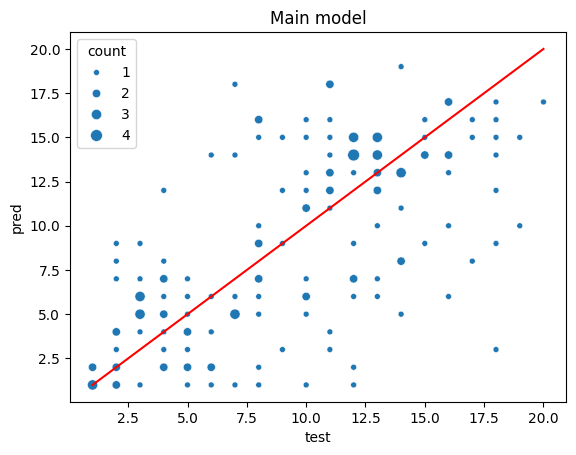

Accuracy of ensembled model: 0.08280254777070063
Decision Tree 0.12738853503184713
Random Forest 0.08917197452229299
Gradient Boosting 0.08917197452229299
Gaussian Naive Bayes 0.08917197452229299
Linear Discriminant Analysis 0.07643312101910828
Quadratic Discriminant Analysis 0.07643312101910828


In [370]:
#df = forecastData()
iterations = 1
for i in range(iterations):
    model = modelFitter(i)
    #y_pred = model.predict(df.drop('result', axis=1))
    #df['result'] = df['result'] + y_pred
#df['result'] = df['result']/iterations
#df = df.sort_values('result').head(5)
#df = df.loc[:, (df != 0).any(axis=0)]

#df